In [1]:
# imports
import random 
import numpy 
import math
import pandas as pd
import matplotlib.pyplot as plt
import time
from itertools import permutations
import sys, heapq
from itertools import chain

## Part 3: Optimizing Minecraft Wheat Farming Stochastically
We start by defining what we are taking in as input and what the output should be. For this case the inputs are the size of a farm (9 by 9 with one water block in the middle), the fastest time all the crops can grow and the slowest the crops can grow. The outputs are the amount of harvested crops, and the time it took for all the crops to be harvested. 

In [1390]:
# harvest function simulates how many wheat will be harvested after a random amount of ticks capped to 2 minecraft days
# takes in the integer n of a size n*n farm where n >= 5, the maximum amount of time before harvesting, the update rate of a crop, and the amount of growth stages a crop takes
# returns the output of wheat when harvesting and at what time in ticks when the wheats were harvested.
def harvest(harvestpoint, size=9, updaterate = 1365, stagesofgrowth = 8):
    # from farm size, find out how many crops are growing at the same time
    # minimum 5 by 5 farm
    crops = (size * size) - 1
    # find out how many of the crops have only 3 adjacent crops
    # these are the corner blocks
    adj3 = 4
    # find out how many of the crops have only 5 adjacent crops
    # these are the sides of a farm excluding the corners
    adj5 = 4 * (size - 2)
    # find out how many of the crops have only 8 adjacent crops
    # these are all of the middle crops
    adj78 = crops - adj3 - adj5
    # checks for condition of crops, if they are not met return a message
    if crops == 0:
        return "No crops found"
    if crops < 16:
        return "Farm too small"
    # set a counter for amount of wheat harvested (minimum is 1)
    wheatcount = 0
    # determine the amount of block updates that happen in the randomly selected time
    amountofupdates = int(harvestpoint/updaterate)
    # probability of crop growth per block update (acquired at reference [3])
    growthprobability78 = (1/3) / 2
    growthprobability5 = (1/4) / 2
    growthprobability3 = (1/5) / 2
    # iterate over each crop whether when it's havested it will produce 1 wheat
    growthprobability = 0
    for i in range(crops):
        # check which probability will be used per iteration
        if i < adj3:
            growthprobability = growthprobability3
        elif i >=adj3 and i < adj5 + adj3:
            growthprobability = growthprobability5
        else:
            growthprobability = growthprobability78
        # initialize the growth stage of the crop
        growthstage = 1
        # iterate over the amount of updates taking place
        for i in range(amountofupdates):
            # if the random value is less than or equal to the growth probability, then the crop grows to it's next stage
            if random.random() <= growthprobability:
                growthstage += 1
        # if the crop grows equal to or more than the amount of stages of growth, a wheat is harvested
        if growthstage >= stagesofgrowth:
            # add one to the wheat counter
            wheatcount += 1
    # return amount of wheat the farm produced
    return wheatcount


In [1391]:
# sample of how the code works
pointtemp = int(random.uniform(0, 72000))
wheattemp = harvest(pointtemp)
print(f'Expected wheat harvested at tick {pointtemp} : {wheattemp}')

Expected wheat harvested at tick 45867 : 18


In [1403]:
# random search over 1000 farm runs
def farmRandomSearch(steps=1000, mintime = 0, maxtime=72000):
    # base case
    bestpoint = int(random.uniform(mintime, maxtime))
    bestwheat = harvest(bestpoint)
    bestratio = bestwheat / bestpoint
    # for every step, make new point, get the wheat harvested and get the ratio
    for i in range(steps):
        newpoint = int(random.uniform(mintime, maxtime))
        newwheat = harvest(pointtemp)
        newratio = bestwheat / bestpoint
        # best ratio determines what value is kept
        if newratio > bestratio:
            bestratio = newratio
            bestwheat = newwheat
            bestpoint = newpoint
    return bestwheat, bestpoint, bestratio

[(56, 70635, 0.0007928080979684293), (55, 69795, 0.0007880220646178094), (55, 71992, 0.0007639737748638737), (45, 60595, 0.0007426355309844046), (51, 68835, 0.0007409021573327523), (44, 59633, 0.0007378464943906897), (50, 68056, 0.0007346890795815211), (47, 64722, 0.000726182750842063), (52, 71696, 0.0007252845347020755), (49, 69494, 0.0007050968428929116)]
Random search on many harvests gives us: 


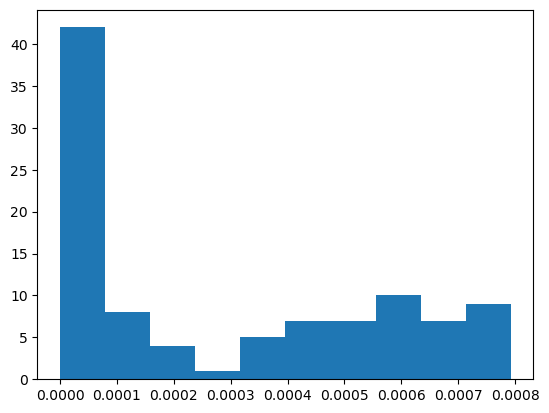

In [1404]:
# multiple runs on random search to find roughly where the best time is
iterations = 100
bestrandomratiolist = []
for i in range(iterations):
    wheattemp, pointtemp, ratiotemp = farmRandomSearch()
    bestrandomratiolist.append((wheattemp, pointtemp, ratiotemp))
bestrandomratiolist.sort(key=lambda item: item[-1], reverse = True)
print(bestrandomratiolist[0:10])
# plot the list of farms and see how consistent it is
flist = []
print("Random search on many harvests gives us: ")
for i in bestrandomratiolist:
    flist.append(i[-1])
plt.hist(flist)
plt.show()

In [1405]:
# hill climb over 1000 farm runs
def farmHillSearch(steps=1000, mintime = 0, maxtime=72000, step_size=1000):
    # define a variable that caps the amount of iterations if the value does not change
    changecap = int(steps * 0.05)
    # define a variable that counts the amount of changes done for a new best f
    changecounter = 0
    # make new random values for x, y and z as a base case
    # base case
    bestpoint = int(random.uniform(mintime, maxtime))
    bestwheat = harvest(bestpoint)
    bestratio = bestwheat / bestpoint
    # for every step, make a change to previous best point, get the wheat harvested and get the ratio
    for i in range(steps):
        newpoint = bestpoint + int(random.gauss(0, step_size))
        if newpoint > maxtime or newpoint < mintime:
            newpoint = bestpoint
        newwheat = harvest(pointtemp)
        newratio = bestwheat / bestpoint
        # best ratio determines what value is kept
        if newratio > bestratio:
            bestratio = newratio
            bestwheat = newwheat
            bestpoint = newpoint
            # reset the change counter because a change has been made
            changecounter = 0
        # add 1 to the change counter to account for each iteration
        changecounter += 1
        # checks if the change counter has passed the cap of iterations without change
        if changecounter > changecap:
            # early return to save on time in case no changes have been made in a while
            return bestwheat, bestpoint, bestratio
    return bestwheat, bestpoint, bestratio

[(51, 63450, 0.0008037825059101655), (54, 68821, 0.0007846442219671321), (54, 69299, 0.0007792320235501234), (49, 65643, 0.0007464619228249775), (52, 69924, 0.0007436645500829472), (44, 63325, 0.0006948282668772207), (44, 63558, 0.0006922810661128419), (46, 67448, 0.0006820068793737398), (44, 65521, 0.000671540422154729), (47, 70388, 0.0006677274535432176)]
Hill Climb on many harvests gives us: 


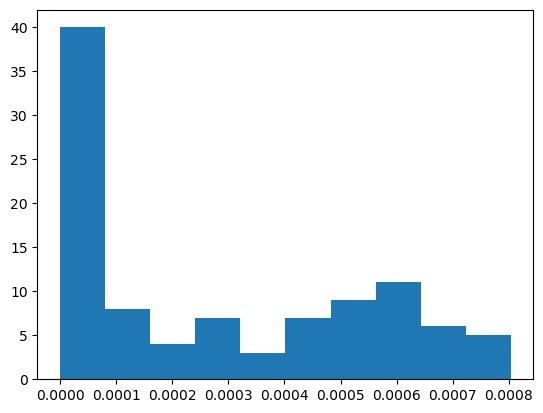

In [1406]:
# multiple runs on hill climb search to find roughly where the best time is
iterations = 100
besthillratiolist = []
for i in range(iterations):
    wheattemp, pointtemp, ratiotemp = farmHillSearch()
    besthillratiolist.append((wheattemp, pointtemp, ratiotemp))
besthillratiolist.sort(key=lambda item: item[-1], reverse = True)
print(besthillratiolist[0:10])
# plot the list of farms and see how consistent it is
flist = []
print("Hill Climb on many harvests gives us: ")
for i in besthillratiolist:
    flist.append(i[-1])
plt.hist(flist)
plt.show()

In [1407]:
# keep a running list of all total ratios
totalratiolist = []
# get all values gathered so far and put them in a list
ratiolist1 = [item for sublist in zip(besthillratiolist, bestrandomratiolist) for item in sublist]
# sort the list
ratiolist1.sort(key=lambda item: item[-1], reverse = True)
totalratiolist = totalratiolist + ratiolist1
totalratiolist.sort(key=lambda item: item[-1], reverse = True)
# print top 30 from the best gathered results
print(totalratiolist[0:30])
# take the top 5% of all results and keep them to determine the new bounds
accepted = int(0.05 * len(totalratiolist))
newtotalratiolist = totalratiolist[0:accepted]
# find lowest and highest values of x, y and z
zip(*newtotalratiolist)
mins = map(min, zip(*newtotalratiolist))
maxs = map(max, zip(*newtotalratiolist))
allbounds = list(mins), list(maxs)
# in case upper bound is overfitted
timebounds = allbounds[0][1], allbounds[1][1]
print(f"Bounds for time: {timebounds} \n")

[(51, 63450, 0.0008037825059101655), (56, 70635, 0.0007928080979684293), (55, 69795, 0.0007880220646178094), (54, 68821, 0.0007846442219671321), (54, 69299, 0.0007792320235501234), (55, 71992, 0.0007639737748638737), (49, 65643, 0.0007464619228249775), (52, 69924, 0.0007436645500829472), (45, 60595, 0.0007426355309844046), (51, 68835, 0.0007409021573327523), (44, 59633, 0.0007378464943906897), (50, 68056, 0.0007346890795815211), (47, 64722, 0.000726182750842063), (52, 71696, 0.0007252845347020755), (49, 69494, 0.0007050968428929116), (44, 63325, 0.0006948282668772207), (44, 63558, 0.0006922810661128419), (46, 67448, 0.0006820068793737398), (44, 64955, 0.0006773920406435225), (44, 65521, 0.000671540422154729), (35, 52392, 0.0006680409222782105), (47, 70388, 0.0006677274535432176), (45, 67691, 0.0006647855697212333), (41, 62074, 0.0006605019815059445), (41, 62132, 0.0006598854052662074), (45, 69462, 0.000647836227001814), (42, 65765, 0.0006386375731772219), (37, 57949, 0.0006384924675145

[(60, 67205, 0.0008927907149765642), (58, 66829, 0.0008678866958954944), (62, 71688, 0.0008648588327195625), (58, 67220, 0.0008628384409401964), (61, 71871, 0.0008487428865606434), (56, 66062, 0.000847688535012564), (55, 65105, 0.0008447891866984103), (60, 71239, 0.0008422352924662053), (59, 70066, 0.0008420631975565895), (60, 71276, 0.000841798080700376)]
Hill Climb on many harvests gives us: 


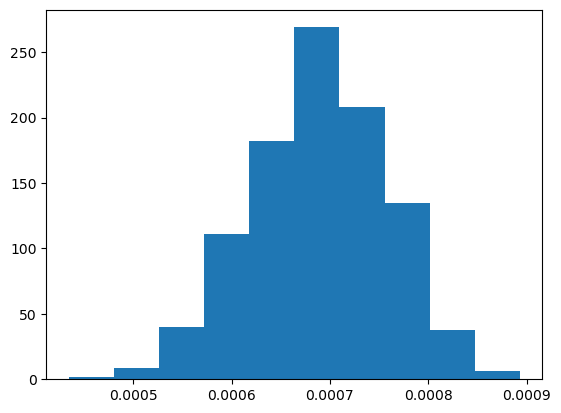

In [1408]:
# multiple runs on hill climb search to find roughly where the best time is
iterations = 1000
besthillratiolist2 = []
for i in range(iterations):
    wheattemp, pointtemp, ratiotemp = farmHillSearch(mintime=timebounds[0], step_size=100)
    besthillratiolist2.append((wheattemp, pointtemp, ratiotemp))
besthillratiolist2.sort(key=lambda item: item[-1], reverse = True)
print(besthillratiolist2[0:10])
# plot the list of farms and see how consistent it is
flist = []
print("Hill Climb on many harvests gives us: ")
for i in besthillratiolist2:
    flist.append(i[-1])
plt.hist(flist)
plt.show()

In [1409]:
# get all values gathered so far and put them in a list
ratiolist2 = [item for sublist in zip(besthillratiolist2) for item in sublist]
# sort the list
ratiolist2.sort(key=lambda item: item[-1], reverse = True)
totalratiolist = totalratiolist + ratiolist2
totalratiolist.sort(key=lambda item: item[-1], reverse = True)
# print top 15 from the best gathered results
print(totalratiolist[0:15])
# take the top 15 of all results and keep them to determine the new bounds
accepted = 15
newtotalratiolist = totalratiolist[0:accepted]
# find lowest and highest values of x, y and z
zip(*newtotalratiolist)
mins = map(min, zip(*newtotalratiolist))
maxs = map(max, zip(*newtotalratiolist))
allbounds = list(mins), list(maxs)
# in case upper bound is overfitted
timebounds = allbounds[0][1], allbounds[1][1]
print(f"Bounds for time: {timebounds} \n")

[(60, 67205, 0.0008927907149765642), (58, 66829, 0.0008678866958954944), (62, 71688, 0.0008648588327195625), (58, 67220, 0.0008628384409401964), (61, 71871, 0.0008487428865606434), (56, 66062, 0.000847688535012564), (55, 65105, 0.0008447891866984103), (60, 71239, 0.0008422352924662053), (59, 70066, 0.0008420631975565895), (60, 71276, 0.000841798080700376), (60, 71336, 0.00084109005270831), (58, 69290, 0.0008370616250541204), (60, 71757, 0.0008361553576654542), (60, 71854, 0.0008350265816795168), (56, 67406, 0.0008307865768625939)]
Bounds for time: (65105, 71871) 



[(63, 71229, 0.0008844712125679147), (61, 70362, 0.0008669452261163696), (58, 66999, 0.0008656845624561561), (57, 66260, 0.00086024750980984), (61, 71075, 0.000858248329229687), (58, 68110, 0.0008515636470415504), (56, 65818, 0.0008508310796438664), (58, 68263, 0.0008496550107671798), (57, 67128, 0.0008491240614944583), (61, 71963, 0.0008476578241596376)]
Hill Climb on many harvests gives us: 


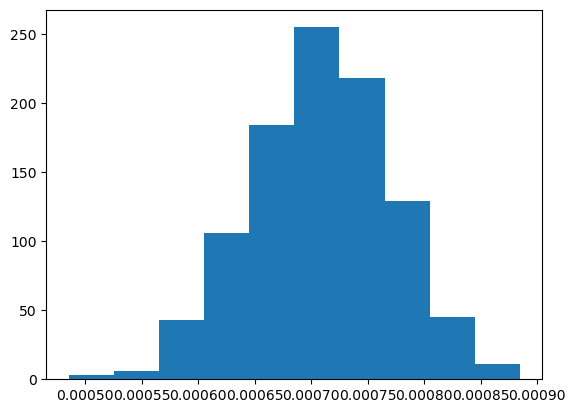

In [1410]:
# multiple runs on hill climb search to find roughly where the best time is
iterations = 1000
besthillratiolist3 = []
for i in range(iterations):
    wheattemp, pointtemp, ratiotemp = farmHillSearch(mintime=timebounds[0], step_size=100)
    besthillratiolist3.append((wheattemp, pointtemp, ratiotemp))
besthillratiolist3.sort(key=lambda item: item[-1], reverse = True)
print(besthillratiolist3[0:10])
# plot the list of farms and see how consistent it is
flist = []
print("Hill Climb on many harvests gives us: ")
for i in besthillratiolist3:
    flist.append(i[-1])
plt.hist(flist)
plt.show()

In [1411]:
# get all values gathered so far and put them in a list
ratiolist3 = [item for sublist in zip(besthillratiolist3) for item in sublist]
# sort the list
ratiolist3.sort(key=lambda item: item[-1], reverse = True)
totalratiolist = totalratiolist + ratiolist3
totalratiolist.sort(key=lambda item: item[-1], reverse = True)
print(totalratiolist[0:15])
# take the top 10 of all results and keep them to determine the new bounds
accepted = 10
newtotalratiolist = totalratiolist[0:accepted]
# find lowest and highest values of x, y and z
zip(*newtotalratiolist)
mins = map(min, zip(*newtotalratiolist))
maxs = map(max, zip(*newtotalratiolist))
allbounds = list(mins), list(maxs)
# in case upper bound is overfitted
timebounds = allbounds[0][1], allbounds[1][1]
print(f"Bounds for time: {timebounds} \n")

[(60, 67205, 0.0008927907149765642), (63, 71229, 0.0008844712125679147), (58, 66829, 0.0008678866958954944), (61, 70362, 0.0008669452261163696), (58, 66999, 0.0008656845624561561), (62, 71688, 0.0008648588327195625), (58, 67220, 0.0008628384409401964), (57, 66260, 0.00086024750980984), (61, 71075, 0.000858248329229687), (58, 68110, 0.0008515636470415504), (56, 65818, 0.0008508310796438664), (58, 68263, 0.0008496550107671798), (57, 67128, 0.0008491240614944583), (61, 71871, 0.0008487428865606434), (56, 66062, 0.000847688535012564)]
Bounds for time: (66260, 71688) 



[(60, 67589, 0.000887718415718534), (63, 71270, 0.000883962396520275), (62, 71241, 0.0008702853693799918), (60, 68950, 0.0008701957940536621), (59, 67839, 0.0008697062161883282), (60, 69030, 0.000869187309865276), (58, 66921, 0.0008666935640531373), (60, 69660, 0.0008613264427217916), (60, 70007, 0.0008570571514277144), (60, 70069, 0.0008562987911915398)]
Hill Climb on many harvests gives us: 


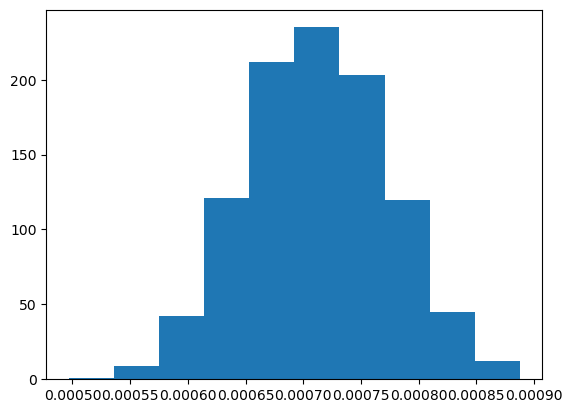

In [1412]:
# multiple runs on hill climb search to find roughly where the best time is
iterations = 1000
besthillratiolist4 = []
for i in range(iterations):
    wheattemp, pointtemp, ratiotemp = farmHillSearch(mintime=timebounds[0], maxtime=timebounds[1], step_size=50)
    besthillratiolist4.append((wheattemp, pointtemp, ratiotemp))
besthillratiolist4.sort(key=lambda item: item[-1], reverse = True)
print(besthillratiolist4[0:10])
# plot the list of farms and see how consistent it is
flist = []
print("Hill Climb on many harvests gives us: ")
for i in besthillratiolist4:
    flist.append(i[-1])
plt.hist(flist)
plt.show()

In [1413]:
# get all values gathered so far and put them in a list
ratiolist4 = [item for sublist in zip(besthillratiolist4) for item in sublist]
# sort the list
ratiolist4.sort(key=lambda item: item[-1], reverse = True)
totalratiolist = totalratiolist + ratiolist4
totalratiolist.sort(key=lambda item: item[-1], reverse = True)
print(totalratiolist[0:10])
# take the top 5 of all results and keep them to determine the new bounds
accepted = 5
newtotalratiolist = totalratiolist[0:accepted]
# find lowest and highest values of x, y and z
zip(*newtotalratiolist)
mins = map(min, zip(*newtotalratiolist))
maxs = map(max, zip(*newtotalratiolist))
allbounds = list(mins), list(maxs)
# in case upper bound is overfitted
timebounds = allbounds[0][1], allbounds[1][1]
print(f"Bounds for time: {timebounds} \n")

[(60, 67205, 0.0008927907149765642), (60, 67589, 0.000887718415718534), (63, 71229, 0.0008844712125679147), (63, 71270, 0.000883962396520275), (62, 71241, 0.0008702853693799918), (60, 68950, 0.0008701957940536621), (59, 67839, 0.0008697062161883282), (60, 69030, 0.000869187309865276), (58, 66829, 0.0008678866958954944), (61, 70362, 0.0008669452261163696)]
Bounds for time: (67205, 71270) 



In [1416]:
print(f'The best time to harvest: {totalratiolist[0][1]} ticks or {totalratiolist[0][1]/24000} minecraft days')
print(f'The expected yield from the harvest: {totalratiolist[0][0]} wheats')
print(f'The best wheat to time ratio: {totalratiolist[0][2]}')
print(f'The best time to harvest a farm lies between {timebounds[0]} and {timebounds[1]} ticks or between {timebounds[0] / 24000} and {timebounds[1] / 24000} minecraft days')
print(f'The expected yield within the time lies between {allbounds[0][0]} and {allbounds[1][0]}')

The best time to harvest: 67205 ticks or 2.8002083333333334 minecraft days
The expected yield from the harvest: 60 wheats
The best wheat to time ratio: 0.0008927907149765642
The best time to harvest a farm lies between 67205 and 71270 ticks or between 2.8002083333333334 and 2.9695833333333335 minecraft days
The expected yield within the time lies between 60 and 63
